Tutorial 4: Dealing With Failure
================================

In the previous tutorial we intentionally made our non-linear search infer a local maxima solution and therefore return
a physically incorrect lens model. In this tutorial, we will pretend that we have modeled our lens and inferred a local
maxima. We introduce three approaches one can take that changes how we fit the model, all of which have the aim of
ensuring we infer the global maxima:

 1) Prior Tuning: Tell the non-linear search where to search parameter space.
 2) Reduce Complexity: Fit a lens model with fewer parameters and therefore a simpler parameter space.
 3) Look Harder: Brute force a global maxima by telling the non-linear search to sample parameter space more thoroughly.

Each approach has its benefits and disadvantages and we will discuss them in detail.

In the previous tutorial, when we inferred a local maxima we knew that we had done so. For modeling a real lens,
we do not know the true lens model and it may be unclear if the solution we infered is a global or local maxima. The
methods we learn in this tutorial are therefore equally important for verifying that a solution that looks like a
global maxima solution is in indeed the global maxima.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import numpy as np
from os import path
import autolens as al
import autolens.plot as aplt
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is an `EllSersic`.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllExponential`.

In [2]:
dataset_name = "light_sersic__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

__Masking__

we'll create and use a smaller 2.0" `Mask2D` again.

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=2.6
)

imaging = imaging.apply_mask(mask=mask)

When plotted, the lens light`s is clearly visible in the centre of the image.

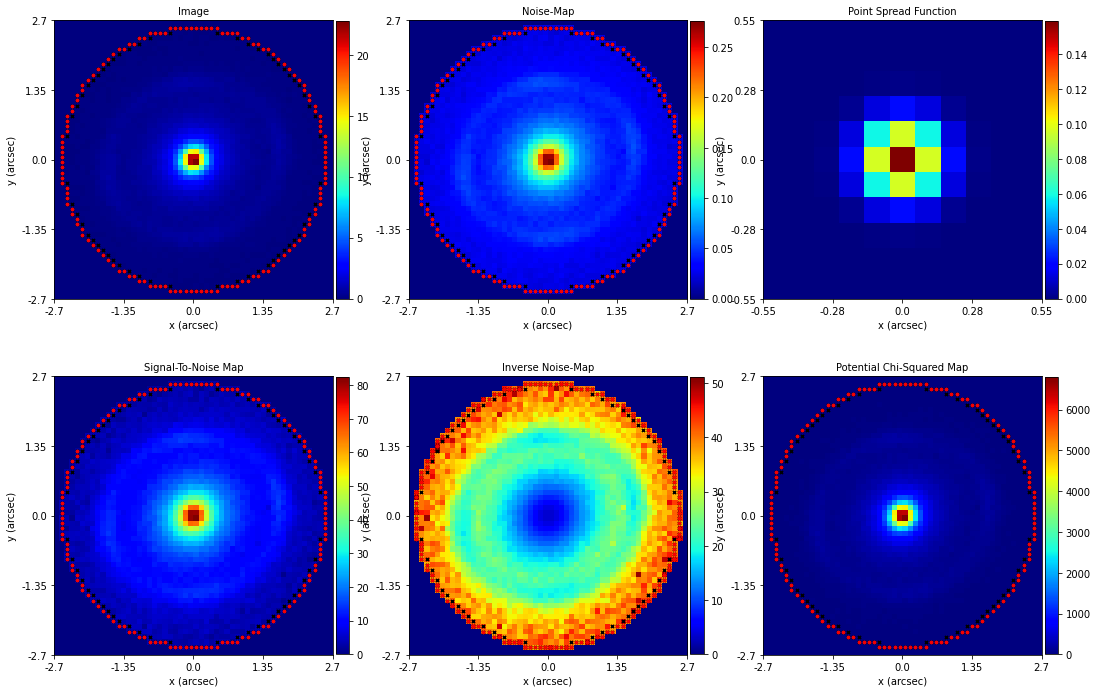

In [4]:
imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Approach 1: Prior Tuning__

First, we are going to try giving our non-linear search a helping hand. Our priors tell  the non-linear search where 
to look in parameter space. If we tell it to look in the right place (that is, 'tune' our priors), this might mean 
the search finds the global solution when it previously found a local maxima.

We saw in a previous tutorial that we can fully customize priors in **PyAutoLens**, so lets give it a go. I've set up 
a custom search below and specified priors that give the non-linear search a better chance of inferring the global 
maxima solution, alongside discussing how I have changed each prior from the default values specified by the 
`config/priors/default` config files.

We will call our lens and source galaxies `lens` and `source` this time, for shorter more readable code.

In a previous tutorial, we customized the priors of a model by creating a `Galaxy` as a `Model` and customizing each
prior:

In [5]:
lens = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.SphIsothermal)
lens.mass.centre_0 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)

We can alternatively create the light and mass profiles as a `Model` and customize their parameters, and then pass them
to the model galaxy and overall model. These two approaches are equivalent, but in this example the style below 
provides more concise and readable code. We will therefore switch to this code style in this tutorial, but may swap 
back and forth between the two styles throughout **HowToLEns** depending on what is more readable.

In [6]:
bulge = af.Model(al.lp.EllSersic)
mass = af.Model(al.mp.EllIsothermal)

By default, the prior on the $(y,x)$ coordinates of a `LightProfile` / `MassProfile` is a GaussianPrior with 
`mean=0.0` and `sigma=0.3`. However, visual inspection of our strong lens image tells us that its centre (based on the
lens galaxy's luminous emission) is at x = 0.0" and y = 0.0", so lets reduce the `sigma` value on this prior so the
non-linear search looks over a very narrow range of `centre` values in parameter space.

In [7]:
bulge.centre.centre_0 = af.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
bulge.centre.centre_1 = af.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
mass.centre.centre_0 = af.UniformPrior(lower_limit=-0.05, upper_limit=0.05)
mass.centre.centre_1 = af.UniformPrior(lower_limit=-0.05, upper_limit=0.05)

By default, the elliptical components of the of our lens galaxy's elliptical `LightProfile` are `GaussianPrior`'s 
with `mean=0.0` and `sigma=0.5`. Note that the solution `elliptical_comps=(0.0, 0.0)` corresponds to a spherical system
and that all physical solutions (e.g. with axis-ratios running from 0.0 -> 1.0 and position angles 0.0 -> 180.0 degrees) 
are encapsulated for solutions where each component runs from -1.0 -> 1.0. 

However, through visual inspection of the image we can often determine the position angle of the lens's light, which 
for this data is clearly 45.0 degrees counter-clockwise from the x-axis. We can update the priors on our elliptical 
components to reflect this. The `lower_limit` and `upper_limit` on a `GaussianPrior` ensure the solutions cannot go
outside the physically plausible range -1.0 -> 1.0.

In [8]:
bulge.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(
    mean=0.333333, sigma=0.1, lower_limit=-1.0, upper_limit=1.0
)
bulge.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(
    mean=0.0, sigma=0.1, lower_limit=-1.0, upper_limit=1.0
)

Lets also assume that the ellipticity of the light profile can be used as a prior on that of the mass profile. This may 
not be strictly true (e.g. because of dark matter) so we will use a wider prior, such that the non-linear search can 
change the mass model's ellipticity from that of the light if fitting the data necessitates it.

In [9]:
mass.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(
    mean=0.333333, sigma=0.3, lower_limit=-1.0, upper_limit=1.0
)
mass.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(
    mean=0.0, sigma=0.3, lower_limit=-1.0, upper_limit=1.0
)

The `effective_radius` of light profile is its 'half-light' radius, the radius at which 50% of its total luminosity 
is internal to a circle defined within that radius. **PyAutoLens** assumes a `UniformPrior` on this quantity between 
0.0" and 30.0". This large range of values is required to cover the size of all possible strong lenses that can be 
observed in the Universe.

However, inspection of this image shows the lens's light does not extend anywhere near 30.0", so lets reduce it.

In [10]:
bulge.effective_radius = af.GaussianPrior(
    mean=1.0, sigma=0.8, lower_limit=0.0, upper_limit=np.inf
)

The `sersic_index` defines how concentrated the light profile is. In galaxy structure studies, values of Sersic index
around 1.0 indicate a disk galaxy, whereas higher values of 3 or 4 indicate an elliptical galaxy. **PyAutoLens**
assumes a `UniformPrior` between 0.8 and 8.0 by default on this parameter, as a user could model strong lenses
where the lens is of any morphology.

We often have knowledge of the lens's morphology before we fit it, so in this example we will assume our lens is
a massive elliptical galaxy with a `sersic_index` near 4.

In [11]:
bulge.sersic_index = af.GaussianPrior(
    mean=4.0, sigma=1.0, lower_limit=0.0, upper_limit=np.inf
)

Finally, the `ring` that the lensed source forms clearly has a radius of about 1.6". This is its Einstein radius, so 
lets change the prior from a UniformPrior between 0.0" and 4.0".

In [12]:
mass.einstein_radius = af.GaussianPrior(
    mean=1.6, sigma=0.2, lower_limit=0.0, upper_limit=np.inf
)

We now compose the overall model, where the lens galaxy model uses the `Model` components above which had their
priors customizes.

In this exercise, I'm not going to change any priors on the source galaxy. Whilst lens modeling experts can look at a 
strong lens and often tell you roughly where the source-galaxy is located (in the source-plane), it is something of art 
form. Furthermore, the source's morphology can be pretty complex, making it difficult to come up with a good source 
prior!

In [13]:
lens = af.Model(
    al.Galaxy,
    redshift=0.5,
    bulge=al.lp.EllSersic,
    mass=al.mp.EllIsothermal,
    shear=al.mp.ExternalShear,
)

source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllExponential)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

We can now create this custom search and run it. Our non-linear search will now start by sampling higher likelihood 
regions of parameter space, given our improved and more informed priors.

In [14]:
search = af.DynestyStatic(
    path_prefix=path.join("howtolens", "chapter_2"),
    name="tutorial_4_custom_priors",
    nlive=50,
    number_of_cores=1,
)

analysis = al.AnalysisImaging(dataset=imaging)

print(
    "Dynesty has begun running - checkout the workspace/output/howtolens/chapter_2/tutorial_4_custom_priors"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result_custom_priors = search.fit(model=model, analysis=analysis)

print("Dynesty has finished run - you may now continue the notebook.")

INFO:root:tutorial_4_custom_priors already completed, skipping non-linear search.


Dynesty has begun running - checkout the workspace/output/howtolens/chapter_2/tutorial_4_custom_priors folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


__Result__

Bam! We get a good model, which corresponds to the global maxima. By giving our non-linear search a helping hand and 
informing it of where to sample parameter space, we can increase the odds that we find the global maxima solution.

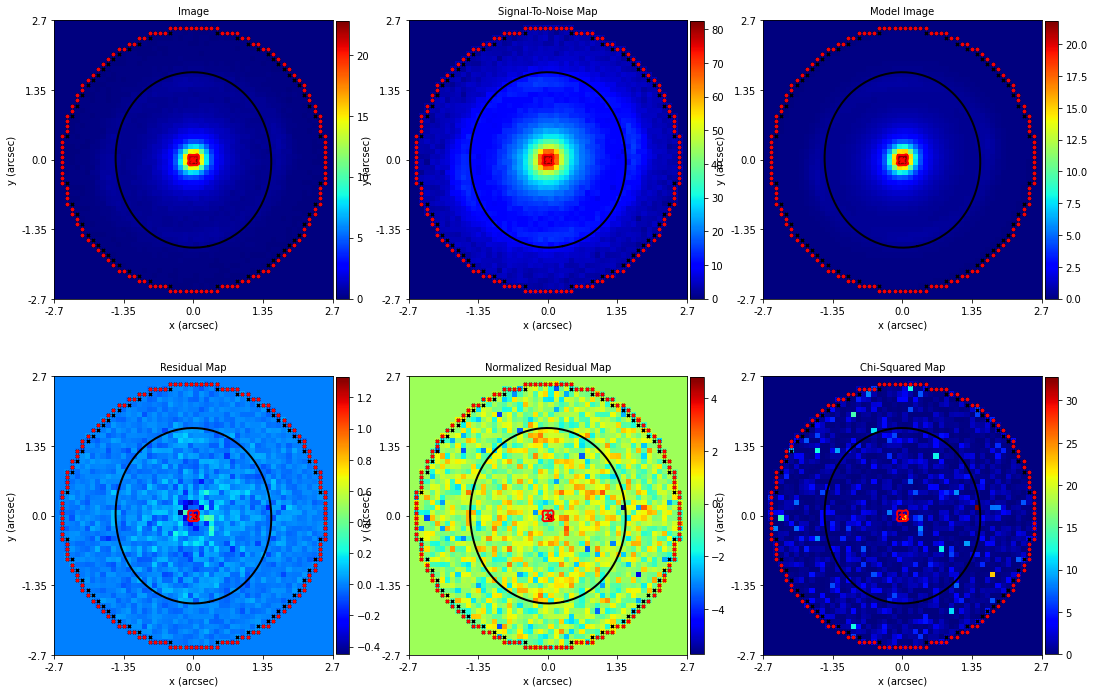

In [15]:
fit_imaging_plotter = aplt.FitImagingPlotter(
    fit=result_custom_priors.max_log_likelihood_fit
)
fit_imaging_plotter.subplot_fit_imaging()

__Discussion__

By tuning our priors to the lens we fit we increase the chance of inferring the global maxima lens model. The search
may also fit the lens model a lot faster, given it spends less time searches regions of parameter space that do not
correspond to good solutions. 

Before moving onto the next approach, lets think about the advantages and disadvantages of prior tuning:

Advantages: 

 - We have a higher chance of finding the globally maximum log likelihood solutions in parameter space.
 - The search took less time to run because the non-linear search explored less of parameter space.

Disadvantages: 

 - If we specified a prior incorrectly the non-linear search will infer an incorrect solution.
 - The priors for the search were tailored to the specific strong lens we fitted. If we are fitting multiple lenses, 
 we would have customize the priors for every single fit, for large samples of lenses this would take a lot of time!

__Approach 2: Reducing Complexity__

The non-linear search may fail because the lens model is too complex, making its parameter space too difficult to 
sample accurately. Can we can make the lens model less complex, whilst keeping it realistic enough to perform our 
scientific study? What assumptions can we make to reduce the number of lens model parameters and therefore 
dimensionality of non-linear parameter space?

Below, we create a search that assumes that light-traces-mass. That  is, the light profile centre and elliptical 
components are perfectly aligned with the centre and elliptical components of the mass profile. This may, or may 
not, be a reasonable assumption, but it`ll remove 4 parameters from the lens model (the centre and elliptical 
components of the mass profile), so it is worth trying!

In [16]:
bulge = af.Model(al.lp.EllSersic)
mass = af.Model(al.mp.EllIsothermal)

To apply our assumption that light traces mass to the model, we `pair` the `centre` and `elliptical_comps` parameters 
by setting them equal to one another. This removes the  parameter on the left-hand side of the pairing from the lens 
model such that when a model is created it has the same value as the parameter on the right-hand side.

In [17]:
mass.centre = bulge.centre
mass.elliptical_comps = bulge.elliptical_comps

We now compose the model, which will have a non-linear parameter space with 4 less dimensions than the fit performed
previously. 

In [18]:
lens = af.Model(
    al.Galaxy,
    redshift=0.5,
    bulge=al.lp.EllSersic,
    mass=al.mp.EllIsothermal,
    shear=al.mp.ExternalShear,
)

source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllExponential)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

We now create this search and run it.

INFO:root:tutorial_4_reducing_complexity already completed, skipping non-linear search.


Dynesty has begun running - checkout the workspace/output/howtolens/chapter_2/tutorial_4_reducing_complexity folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


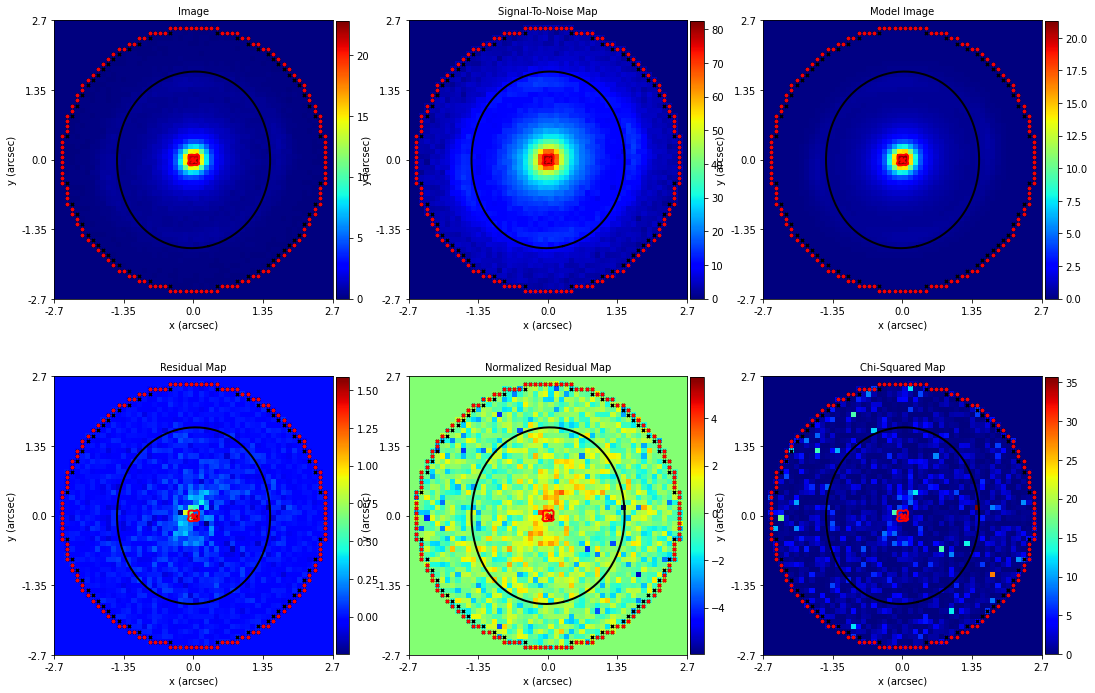

In [19]:
search = af.DynestyStatic(
    path_prefix=path.join("howtolens", "chapter_2"),
    name="tutorial_4_reducing_complexity",
    nlive=50,
    number_of_cores=1,
)

print(
    "Dynesty has begun running - checkout the workspace/output/howtolens/chapter_2/tutorial_4_reducing_complexity"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result_light_trace_mass = search.fit(model=model, analysis=analysis)

print("Dynesty has finished run - you may now continue the notebook.")

fit_imaging_plotter = aplt.FitImagingPlotter(
    fit=result_light_trace_mass.max_log_likelihood_fit
)
fit_imaging_plotter.subplot_fit_imaging()

__Result__

The results look pretty good. Our source galaxy fits the data pretty well and we've clearly inferred a model that 
looks similar to the one above. However, inspection of the residuals shows that the fit was not quite as good as the 
first search.

It turns out that for this simulated lens, light did not perfectly trace mass. The light profile's elliptical components 
were (0.333333, 0.0), whereas those of the mass profile. The quality of the fit suffered and the highest value of log 
likelihood wthe search inferred was lower as a result.

Herein lies the pitfalls of making assumptions, they may make your model less realistic and your fits worse! 

__Discussion__

Again, lets consider the advantages and disadvantages of this approach:

Advantages:

 - By reducing parameter space`s complexity we again had a higher chance of inferring the global maximum log 
 likelihood and the time required by the search to do this is reducing.
 - Unlike tuned priors, the search was not specific to one lens and we could run it on many strong lens images.
    
Disadvantages:

 - Our model was less realistic and our fit suffered as a result.

__Approach 3: Look Harder__

In approaches 1 and 2 we extended our non-linear search an olive branch and helped it find the highest log likelihood 
regions of parameter space. In approach 3 ,we're going to tell it to just `look harder`.

Every non-linear search has settings which govern how thoroughly it searches parameter space, with the number of live
points that was passed to Dynesty an example of such a setting. The more thoroughly the search looks, the more likely 
it is that it`ll find the global maximum lens model. However,  the search will also take longer!

Below, we create a more thorough dynesty search, that uses `nlive=200` and `walks=10`. What these settings
are actually changing is discussed in the optional tutorial `howtolens/chapter_optional/tutorial_searches.ipynb`.

Due to the long run times of this search, we comment it output below so it does not run. Feel free to undo these
comments so the script runs faster.

In [20]:
lens = af.Model(
    al.Galaxy,
    redshift=0.5,
    bulge=al.lp.EllSersic,
    mass=al.mp.EllIsothermal,
    shear=al.mp.ExternalShear,
)

source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllExponential)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

search = af.DynestyStatic(
    path_prefix=path.join("howtolens", "chapter_2"),
    name="tutorial_4_look_harder",
    nlive=200,
    walks=10,
    number_of_cores=1,
)

print(
    "Dynesty has begun running - checkout the workspace/output/howtolens/chapter_2/tutorial_4_look_harder"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

# result_look_harder = search.fit(model=model, analysis=analysis)

print("Dynesty has finished run - you may now continue the notebook.")

# fit_imaging_plotter = aplt.FitImagingPlotter(
#     fit=result_look_harder.max_log_likelihood_fit
# )
# fit_imaging_plotter.subplot_fit_imaging()

Dynesty has begun running - checkout the workspace/output/howtolens/chapter_2/tutorial_4_look_harder folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


lets list the advantages and disadvantages of simply adjusting the non-linear search:

Advantages:

 - Its easy to setup, we simply change settings of the non-linear search.
    
 - It generalizes to any strong lens.
 
 - We can make our lens model as complex as we want.

Disadvantage:
 
 - Its potentially expensive. Very expensive. For very complex models, the run times can hours, days, weeks or, dare 
 I say it, months!

So, we can now fit strong lenses with **PyAutoLens**. And when it fails, we know how to get it to work. 

In chapter 3 of **HowToLens**, we will introduce a technique called 'non-linear search chaining', which performs a model 
fit by chaining together multiple searches back-to-back . This allows us to combine the 3 different approaches 
discussed and exploit the advantages of each, whilst not being hindered by their disadvantages.

With search chaining, we can:

 - Fit simpler models with lower dimensionality parameter spaces in the earlier searches and gradually increase the
  lens model complexity search-by-search, guiding the model-fit to a sufficiently realistic lens model. 
  
 - In these earlier searches (with easier to sample parameter spaces), use fast non-linear search settings to compute 
 the results quickly and switch to slower settings in later searches when we fit more complex lens models.

 - Use 'prior passing' to setup the priors of each parameter in the later searches, based on the lens models inferred 
 by the earlier searches. We can therefore guide each search on how to sample a complex lens model's parameter space 
 in a way that can be fully generalized to any strong lens.
 
To wrap up chapter 2, we have a few more tutorials, where we will discuss masking in more detail, the `Result` object
and how to make **PyAutoLens** run faster.